In [25]:
#IMPORTING LIBRARIES
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



In [26]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MONISHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MONISHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MONISHA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\MONISHA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [27]:
# Load the dataset
df = pd.read_csv('IMDB Dataset.csv')
df.head(10)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [28]:
# Text preprocessing function
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords.words('english')]  # Remove stopwords and lemmatize
    return ' '.join(tokens)

In [29]:
# Apply preprocessing to the dataset
df['cleaned_review'] = df['review'].apply(preprocess_text)


In [30]:
df['cleaned_review'].head(15)

0     one reviewer mentioned watching 1 oz episode y...
1     wonderful little production filming technique ...
2     thought wonderful way spend time hot summer we...
3     basically there family little boy jake think t...
4     petter matteis love time money visually stunni...
5     probably alltime favorite movie story selfless...
6     sure would like see resurrection dated seahunt...
7     show amazing fresh innovative idea 70 first ai...
8     encouraged positive comment film looking forwa...
9     like original gut wrenching laughter like movi...
10    phil alien one quirky film humour based around...
11    saw movie 12 came recall scariest scene big bi...
12    im big fan boll work many enjoyed movie postal...
13    cast played shakespeareshakespeare losti appre...
14    fantastic movie three prisoner become famous o...
Name: cleaned_review, dtype: object

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [32]:
# Extract keywords using TF-IDF
vectorizer = TfidfVectorizer(max_features=50, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['cleaned_review'])
keywords = vectorizer.get_feature_names_out()

In [33]:
keywords

array(['acting', 'actor', 'also', 'bad', 'best', 'better', 'character',
       'could', 'dont', 'end', 'even', 'ever', 'film', 'first', 'get',
       'go', 'good', 'great', 'know', 'life', 'like', 'little', 'look',
       'love', 'made', 'make', 'many', 'movie', 'much', 'never', 'one',
       'people', 'plot', 'really', 'say', 'scene', 'see', 'seen', 'show',
       'story', 'take', 'thing', 'think', 'time', 'two', 'watch', 'way',
       'well', 'would', 'year'], dtype=object)

In [34]:
!pip install textblob


In [35]:
from textblob import TextBlob

def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    
    # Define threshold for outlier detection (adjust as needed)
    if polarity < -1 or polarity > 1:
        return None  # Return None for outliers
    else:
        return polarity

df['sentiment'] = df['cleaned_review'].apply(get_sentiment)
df['sentiment'].head(5)

0    0.023881
1    0.127604
2    0.264732
3   -0.042188
4    0.244901
Name: sentiment, dtype: float64

In [36]:
#Calculate keyword frequencies
import numpy as np
keyword_freq = X.toarray().sum(axis=0)
    
# Outlier detection for frequency
q1, q3 = np.percentile(keyword_freq, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
keyword_freq_filtered = np.where((keyword_freq >= lower_bound) & (keyword_freq <= upper_bound), keyword_freq, 0)
    
# Create importance DataFrame
importance_df = pd.DataFrame({
'keyword': keywords,
'frequency': keyword_freq_filtered
})


In [37]:
# Calculate average sentiment for each keyword
sentiments = []
for keyword in keywords:
    mask = df['cleaned_review'].str.contains(keyword)
    sentiments.append(df[mask]['sentiment'].mean())
    
importance_df['sentiment'] = sentiments
importance_df['importance'] = importance_df['frequency'] * np.abs(importance_df['sentiment'])
importance_df = importance_df.sort_values(by='importance', ascending=False)

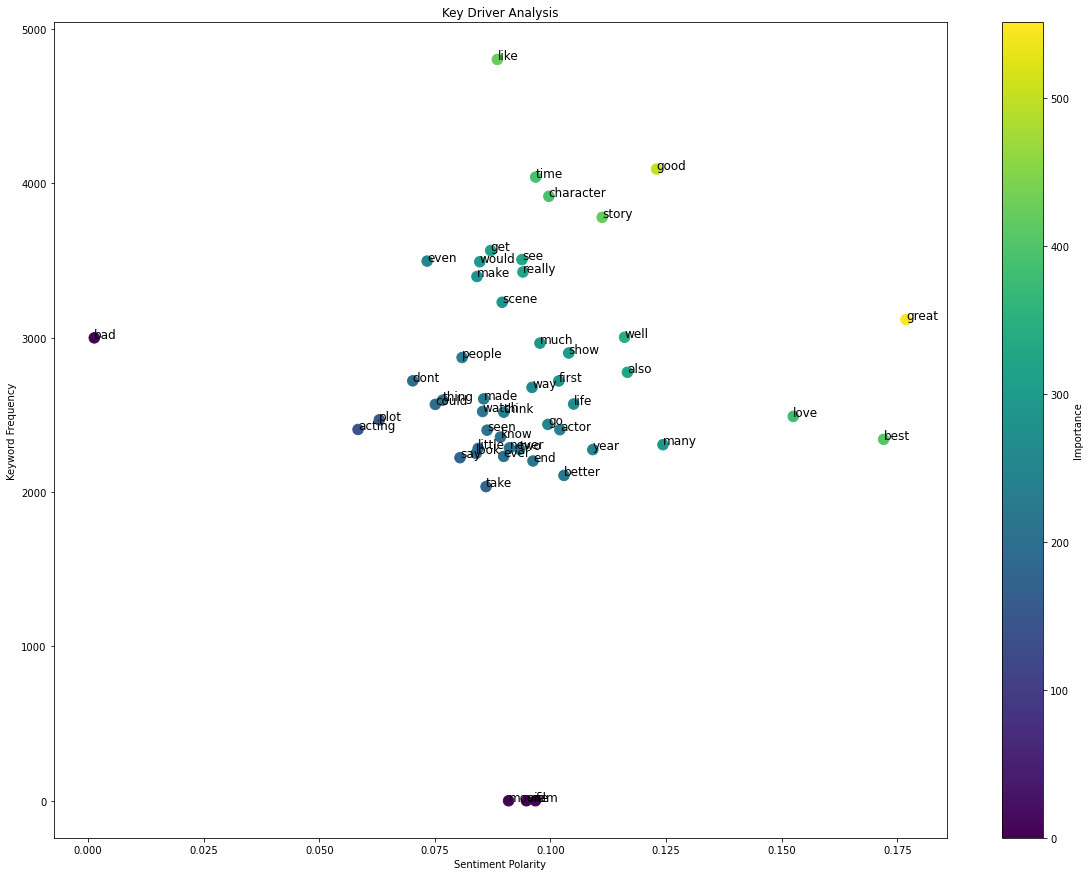

In [40]:
#PLOTTING THE RESULTS
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
plt.scatter(importance_df['sentiment'], importance_df['frequency'], c=importance_df['importance'], cmap='viridis', s=110)
plt.colorbar(label='Importance')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Keyword Frequency')
plt.title('Key Driver Analysis')
for i, row in importance_df.iterrows():
    plt.annotate(row['keyword'], (row['sentiment'], row['frequency']), fontsize=12, alpha=1)
plt.show()
